Data integration with scvi 
----
scVI dataintegration for SEA annotated data (with NaNs)

## Dependecy notebooks

TODO: define here links to other notebooks which need to be run in the correct order prior
to running this notebook (e.g. data preprocessing/data generation).
If there aren't any, remove this section.  
Also name your notebooks beginning with numbers: 01_quality_control.ipynb, 02_normalisation.ipynb, ...

## Import packages

If you want modules to be automatically reloaded when you call them, use `autoreload`:

In [1]:
%load_ext autoreload
%autoreload 2

Import packages

In [2]:
# import standard packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
from pathlib import Path

# import single-cell packages
import scanpy as sc
import scvi

# set verbosity levels
sc.settings.verbosity = 2

import scib

import warnings
warnings.filterwarnings("ignore")

/ictstr01/groups/ml01/workspace/francesca.drummer/mamba/envs/integration/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#!pip install --user scikit-misc

## Print package versions for reproducibility

If you want to exactly reproduce the results shown here, please make sure that your package versions match what is printed below. 

## Set up paths

Define global paths.

In [4]:
sys.path.insert(0, "../")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, RESULTS_DIR, FIG_DIR
from colors import CELL_TYPES_COLOR, CONDITION_COLOR, AREA_COLOR

Set up the paths to save figures.

In [5]:
sc.settings.figdir = str(FIG_DIR)
#scv.settings.figdir = str(FIG_DIR)
#cr.settings.figdir = str(FIG_DIR)

## Set global parameters

Set some plotting parameters.

In [6]:
plt.rcParams['figure.dpi'] = 90
plt.rcParams['savefig.dpi'] = 300 # If 'figure', uses the figure's dpi value.
SMALL_SIZE = 17
MEDIUM_SIZE = 19
BIGGER_SIZE = 21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [7]:
NR_HVG = 5000

If there are other global parameters for this analysis, put them here as well. 

## Define utility functions

Any utility functions you may need in this notebook go here. 

In [8]:
from utils.utils import SAMPLES, VERSION

In [9]:
from IPython.display import Markdown, display


def printmd(string):
    display(Markdown(string))

## Load the data

In [10]:
adata = sc.read_h5ad(DATA_DIR / f"{VERSION}_adata_annotated_sea.h5ad")
adata

AnnData object with n_obs × n_vars = 29656 × 34859
    obs: 'sample', 'condition', 'area', 'age', 'donor', 'sequencing batch', 'sequencing id', 'sex', 'APOE genotype', 'brain area number', 'running number', 'donor_v2', 'donor_v2_area', 'n_counts', 'log_counts', 'n_genes', 'tech_sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_nuclear', 'log1p_total_counts_nuclear', 'pct_counts_nuclear', 'braak_stage', 'area_abbrev', 'condition_area', 'brainbank', 'brain_area_latin', 'soupx_groups', 'scDblFinder_score', 'scDblFinder_class', 'leiden', 'mt_groups', 'tech_sample_2', 'log1p_counts', 'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_2.0', 'celltype', 'cell_type', 'cell_type_sea'
    var: 'ensemble_id', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'ribo', 'hb', 'nuclear', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_co

In [11]:
if 'unannotated' not in adata.obs['cell_type_sea'].cat.categories:
    adata.obs['cell_type_sea'] = adata.obs['cell_type_sea'].cat.add_categories('unannotated')

# Now replace NaN with 'unannotated'
adata.obs['cell_type_sea'] = adata.obs['cell_type_sea'].fillna('unannotated')

In [12]:
np.unique(adata.obs['cell_type_sea'])

array(['Endo', 'GABANeuron', 'GlutaNeuron', 'Micro', 'OPC', 'Oligo',
       'VLMC', 'astro', 'unannotated'], dtype=object)

In [13]:
# filter out all genes that occur in less than 20 cells
adata = adata[:, (adata.layers['raw'] > 0.).sum(axis=0) > 20.].copy()
adata

AnnData object with n_obs × n_vars = 29656 × 34857
    obs: 'sample', 'condition', 'area', 'age', 'donor', 'sequencing batch', 'sequencing id', 'sex', 'APOE genotype', 'brain area number', 'running number', 'donor_v2', 'donor_v2_area', 'n_counts', 'log_counts', 'n_genes', 'tech_sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_nuclear', 'log1p_total_counts_nuclear', 'pct_counts_nuclear', 'braak_stage', 'area_abbrev', 'condition_area', 'brainbank', 'brain_area_latin', 'soupx_groups', 'scDblFinder_score', 'scDblFinder_class', 'leiden', 'mt_groups', 'tech_sample_2', 'log1p_counts', 'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_2.0', 'celltype', 'cell_type', 'cell_type_sea'
    var: 'ensemble_id', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'ribo', 'hb', 'nuclear', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_co

In [14]:
adata.X = adata.layers["raw"].copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers["logcounts"] = adata.X.copy()

normalizing counts per cell
    finished (0:00:12)


brain bank source, sequencing batch

## Unintegrated data

Can we see a batch effect for unintegrated data for patients, cortex areas or their combination?

In [15]:
adata.uns['cell_type_sea_colors'] = list(CELL_TYPES_COLOR.values())
adata.uns['area_colors'] = list(AREA_COLOR.values())
adata.uns['condition_colors'] = list(CONDITION_COLOR.values())

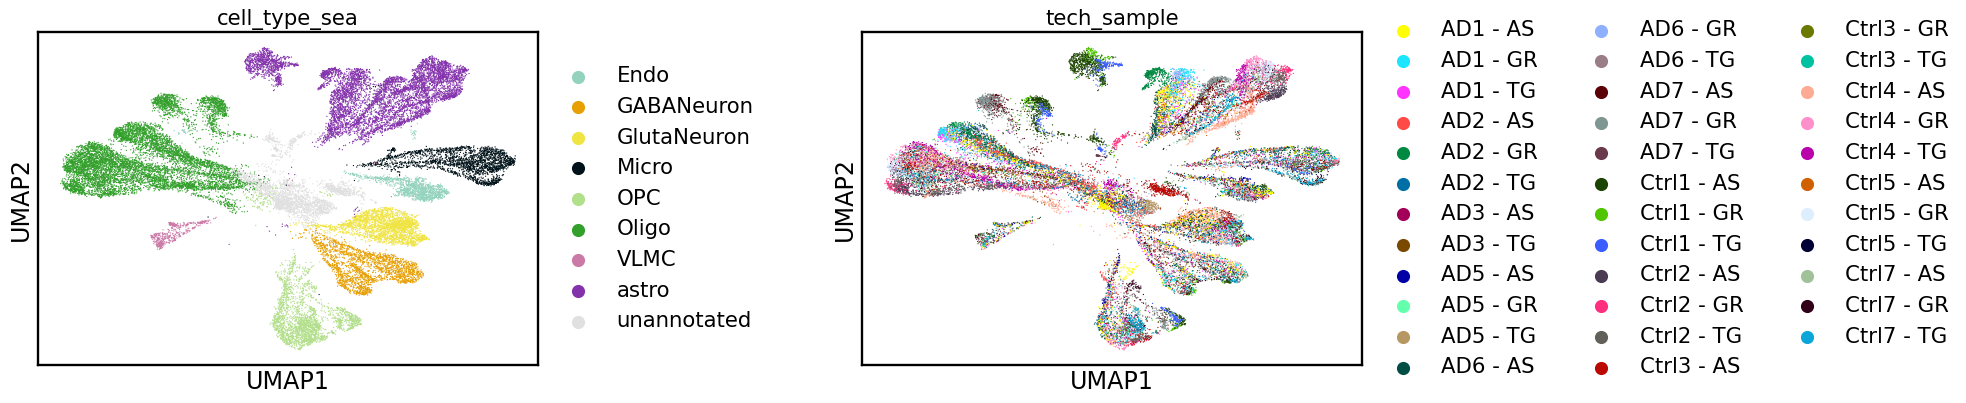

In [16]:
sc.pl.umap(adata, color=["cell_type_sea", "tech_sample"], wspace=0.5)

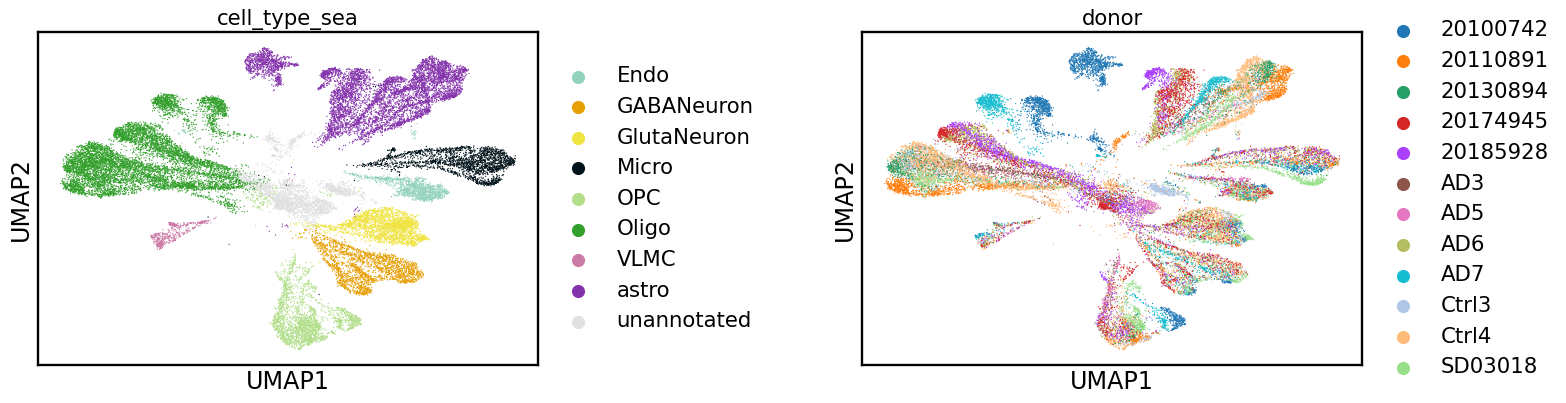

In [17]:
sc.pl.umap(adata, color=["cell_type_sea", "donor"], wspace=0.5)

## Batch-aware feature selection

In [18]:
batch_key = "donor"

In [19]:
sc.pp.highly_variable_genes(
    adata, n_top_genes=NR_HVG, flavor="cell_ranger", batch_key=batch_key
)

extracting highly variable genes
    finished (0:00:05)


In [20]:
for key, value in adata.uns.items():
    print(f"{key}: {type(value)}")

area_colors: <class 'list'>
brain area latin_colors: <class 'numpy.ndarray'>
cell_type_colors: <class 'numpy.ndarray'>
cell_type_sea_colors: <class 'list'>
condition_colors: <class 'list'>
leiden: <class 'dict'>
leiden_res_0.5: <class 'dict'>
leiden_res_0.5_colors: <class 'numpy.ndarray'>
leiden_res_1.0: <class 'dict'>
leiden_res_1.0_colors: <class 'numpy.ndarray'>
leiden_res_2.0: <class 'dict'>
leiden_res_2.0_colors: <class 'numpy.ndarray'>
neighbors: <class 'dict'>
pca: <class 'dict'>
sample_colors: <class 'numpy.ndarray'>
scDblFinder_class_colors: <class 'numpy.ndarray'>
tech_sample_colors: <class 'numpy.ndarray'>
umap: <class 'dict'>
log1p: <class 'dict'>
donor_colors: <class 'list'>
hvg: <class 'dict'>


highly_variable_nbatches
0     16845
1      6230
2      3591
3      2363
4      1641
5      1038
6       729
12      585
7       476
11      407
8       345
10      321
9       286
Name: count, dtype: int64

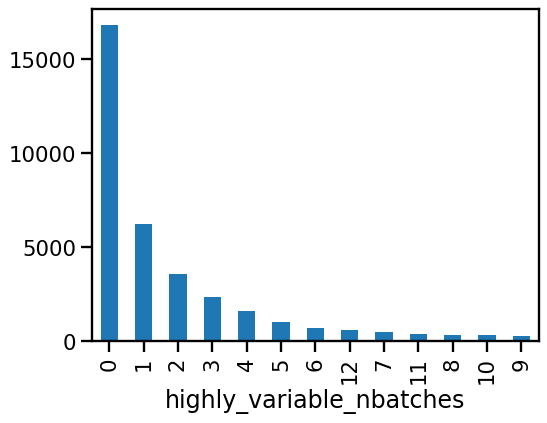

In [21]:
n_batches = adata.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar", width=0.5)
n_batches

In [22]:
adata_hvg = adata[:, adata.var["highly_variable"]].copy()
adata_hvg

AnnData object with n_obs × n_vars = 29656 × 5000
    obs: 'sample', 'condition', 'area', 'age', 'donor', 'sequencing batch', 'sequencing id', 'sex', 'APOE genotype', 'brain area number', 'running number', 'donor_v2', 'donor_v2_area', 'n_counts', 'log_counts', 'n_genes', 'tech_sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_nuclear', 'log1p_total_counts_nuclear', 'pct_counts_nuclear', 'braak_stage', 'area_abbrev', 'condition_area', 'brainbank', 'brain_area_latin', 'soupx_groups', 'scDblFinder_score', 'scDblFinder_class', 'leiden', 'mt_groups', 'tech_sample_2', 'log1p_counts', 'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_2.0', 'celltype', 'cell_type', 'cell_type_sea'
    var: 'ensemble_id', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'ribo', 'hb', 'nuclear', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_cou

In [23]:
print(adata.X[:10,:10])

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 9 stored elements and shape (10, 10)>
  Coords	Values
  (0, 0)	0.6106836795806885
  (1, 2)	1.339258074760437
  (1, 5)	1.339258074760437
  (2, 2)	1.7780861854553223
  (4, 5)	1.8562979698181152
  (5, 0)	1.9668532609939575
  (8, 2)	1.0845879316329956
  (8, 3)	0.3984775245189667
  (9, 4)	0.663905680179596


## Batch aware feature selection

In [24]:
adata.X = adata.layers['X_log']

In [25]:
label_key = "cell_type_sea"
batch_key = "donor"

In [26]:
adata

AnnData object with n_obs × n_vars = 29656 × 34857
    obs: 'sample', 'condition', 'area', 'age', 'donor', 'sequencing batch', 'sequencing id', 'sex', 'APOE genotype', 'brain area number', 'running number', 'donor_v2', 'donor_v2_area', 'n_counts', 'log_counts', 'n_genes', 'tech_sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_nuclear', 'log1p_total_counts_nuclear', 'pct_counts_nuclear', 'braak_stage', 'area_abbrev', 'condition_area', 'brainbank', 'brain_area_latin', 'soupx_groups', 'scDblFinder_score', 'scDblFinder_class', 'leiden', 'mt_groups', 'tech_sample_2', 'log1p_counts', 'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_2.0', 'celltype', 'cell_type', 'cell_type_sea'
    var: 'ensemble_id', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'ribo', 'hb', 'nuclear', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_co

In [27]:
adata_copy = adata.copy()
sc.pp.filter_genes(adata_copy, min_counts=1)
sc.pp.highly_variable_genes(
    adata_copy,
    flavor="seurat",
    n_top_genes=NR_HVG,
    batch_key=batch_key,
    subset=True
)

extracting highly variable genes
    finished (0:00:04)


`highly_variable_nbatches` - The number of batches where each gene was found to be highly variable

highly_variable_nbatches
0     16845
1      6230
2      3591
3      2363
4      1641
5      1038
6       729
12      585
7       476
11      407
8       345
10      321
9       286
Name: count, dtype: int64

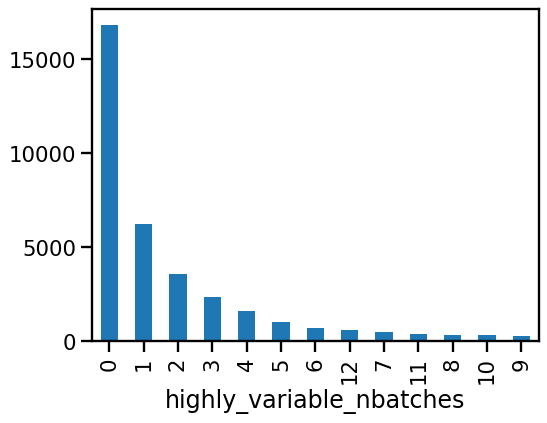

In [28]:
n_batches = adata.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

The plot above shows the number of batches where each gene was found highly variable. We can see that most genes are not highly variable across different samples. 

In [29]:
adata_hvg = adata[:, adata.var["highly_variable"]].copy()
adata_hvg

AnnData object with n_obs × n_vars = 29656 × 5000
    obs: 'sample', 'condition', 'area', 'age', 'donor', 'sequencing batch', 'sequencing id', 'sex', 'APOE genotype', 'brain area number', 'running number', 'donor_v2', 'donor_v2_area', 'n_counts', 'log_counts', 'n_genes', 'tech_sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_nuclear', 'log1p_total_counts_nuclear', 'pct_counts_nuclear', 'braak_stage', 'area_abbrev', 'condition_area', 'brainbank', 'brain_area_latin', 'soupx_groups', 'scDblFinder_score', 'scDblFinder_class', 'leiden', 'mt_groups', 'tech_sample_2', 'log1p_counts', 'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_2.0', 'celltype', 'cell_type', 'cell_type_sea'
    var: 'ensemble_id', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'ribo', 'hb', 'nuclear', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_cou

## scVI Integration

In [30]:
max_epochs_scvi = int(np.min([round((20000 / adata.n_obs) * 400), 400]))
max_epochs_scvi

270

In [31]:
adata_scvi = adata_hvg.copy()

In [32]:
scvi.model.SCVI.setup_anndata(adata_scvi, layer="raw", batch_key=batch_key)

In [33]:
vae = scvi.model.SCVI(adata_scvi, n_layers=2, n_latent=30, gene_likelihood="nb")

In [ ]:
vae.train(max_epochs = max_epochs_scvi)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 2/270:   0%|          | 1/270 [01:00<4:29:49, 60.18s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=2.13e+3]

In [ ]:
adata_scvi.obsm["X_scVI"] = vae.get_latent_representation()

In [ ]:
sc.pp.neighbors(adata_scvi, use_rep="X_scVI")
#sc.tl.leiden(adata_scvi)
sc.tl.umap(adata_scvi)
adata_scvi

In [ ]:
#del adata_scvi.uns[label_key + "_colors"]
adata_scvi.uns["cell_type_sea_colors"] = CELL_TYPES_COLOR.values() 
sc.pl.umap(adata_scvi, color=[label_key, batch_key], wspace=1)

In [ ]:
sc.pl.umap(adata_scvi, color=[label_key, "donor"], wspace=1)

In [ ]:
sc.pl.umap(adata_scvi, color=[label_key, "area"], wspace=1)

In [ ]:
sc.pl.umap(adata_scvi, color=[label_key, "brainbank"], wspace=1)

In [ ]:
adata_scvi.write(DATA_DIR / f"{VERSION}_adata_sea_scVI_{batch_key}.h5ad")

## scANVI

Batch aware integration using cell labels

In [ ]:
print(adata.obs["cell_type_sea"].unique())  # Check if categories match
print(adata.obs["cell_type_sea"].isna().sum())  # Check for NaNs

In [ ]:
model_scanvi = scvi.model.SCANVI.from_scvi_model(
    vae, labels_key=label_key, unlabeled_category="unlabelled"
)

In [ ]:
max_epochs_scvi = np.min([round((20000 / adata.n_obs) * 400), 400])
max_epochs_scvi

In [ ]:
max_epochs_scanvi = int(np.min([10, np.max([2, round(max_epochs_scvi / 3.0)])]))
model_scanvi.train(max_epochs=max_epochs_scanvi)

In [ ]:
adata_scanvi = adata_scvi.copy()
adata_scanvi.obsm["X_scANVI"] = model_scanvi.get_latent_representation()
sc.pp.neighbors(adata_scanvi, use_rep="X_scANVI")
sc.tl.umap(adata_scanvi)
sc.pl.umap(adata_scanvi, color=[label_key, batch_key], wspace=1)

In [ ]:
adata_scanvi.write(DATA_DIR / f"{VERSION}_adata_sea_integrated_{batch_key}.h5ad")

## Metric

In [ ]:
adata_scanvi.write(DATA_DIR / f"{VERSION}_adata_sea_integrated_{batch_key}.h5ad")

In [ ]:
adata.obs[label_key]

In [ ]:
del adata.uns['hvg'], adata_scvi.uns['hvg']

In [ ]:
adata = adata[adata.obs[label_key].notna()] 
adata_scvi = adata_scvi[adata_scvi.obs[label_key].notna()] 
adata_hvg = adata_hvg[adata_hvg.obs[label_key].notna()] 
adata_scanvi = adata_scanvi[adata_scanvi.obs[label_key].notna()] 

In [ ]:
metrics_scvi = scib.metrics.metrics_fast(
    adata, adata_scvi, batch_key, label_key, embed="X_scVI"
)
metrics_scanvi = scib.metrics.metrics_fast(
    adata, adata_scanvi, batch_key, label_key, embed="X_scANVI"
)
metrics_hvg = scib.metrics.metrics_fast(adata, adata_hvg, batch_key, label_key)

In [ ]:
# Concatenate metrics results
metrics = pd.concat(
    [metrics_scvi, metrics_scanvi, metrics_hvg],
    axis="columns",
)
# Set methods as column names
metrics = metrics.set_axis(
    ["scVI", "scANVI", "Unintegrated"], axis="columns"
)
# Select only the fast metrics
metrics = metrics.loc[
    [
        "ASW_label",
        "ASW_label/batch",
        "PCR_batch",
        "isolated_label_silhouette",
        "graph_conn",
        "hvg_overlap",
    ],
    :,
]
# Transpose so that metrics are columns and methods are rows
metrics = metrics.T
# Remove the HVG overlap metric because it's not relevant to embedding outputs
metrics = metrics.drop(columns=["hvg_overlap"])
metrics

Explanation about metrics in paper: [Benchmarking atlas-level data integration in single-cell genomics](https://www.nature.com/articles/s41592-021-01336-8)

ASW (average silhouette width): range -1 to 1; representation of how well seperated clusters are (0/-1 overlapping clusters)

- compares within-cluster distance of a cell and the between-cluster distance of that cell to the closest cluster

ASW_label (bio-conservation score): computed on cell identity labels

ASW_label/batch: 

PCR: ???



In [ ]:
metrics.style.background_gradient(cmap="Blues")

In [ ]:
metrics_scaled = (metrics - metrics.min()) / (metrics.max() - metrics.min())
metrics_scaled.style.background_gradient(cmap="Blues")

In [ ]:
metrics_scaled["Batch"] = metrics_scaled[
    ["ASW_label/batch", "PCR_batch", "graph_conn"]
].mean(axis=1)
metrics_scaled["Bio"] = metrics_scaled[["ASW_label", "isolated_label_silhouette"]].mean(
    axis=1
)
metrics_scaled.style.background_gradient(cmap="Blues")

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
metrics_scaled.plot.scatter(
    x="Batch",
    y="Bio",
    c=range(len(metrics_scaled)),
    ax=ax,
)

for k, v in metrics_scaled[["Batch", "Bio"]].iterrows():
    ax.annotate(
        k,
        v,
        xytext=(6, -3),
        textcoords="offset points",
        family="sans-serif",
        fontsize=12,
    )

In [ ]:
metrics_scaled["Overall"] = 0.4 * metrics_scaled["Batch"] + 0.6 * metrics_scaled["Bio"]
metrics_scaled.style.background_gradient(cmap="Blues")

In [ ]:
metrics_scaled.plot.bar(y="Overall")

# Conclusion

[29.07.24]

Difficult to decide on batch_key for integration because 

- area/condition: biological effect of interest
- donor: possibly for better cell type annotation but prone to filter out biological donor effects
- tech sample: too many batches, not sure what then is integrated

Integration would be most useful when integrating with another dataset.

In [ ]:
# remove NaN

# calculate UMAP
# save